In [52]:
import sys
sys.path.insert(0, "../")
from pathlib import Path
import joblib
import lightning as pl
import torch
from torchvision.io import read_image
from torchvision import transforms
from PIL import Image

import pandas as pd
import numpy as np
from tqdm import tqdm

from artstract_ml.dataset import load_perceptual_dataset, load_image_dataset
from artstract_ml.models.nn import VGG16ImageClassifier, ResNet50ImageClassifier, ViTImageClassifier

from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

import matplotlib.pyplot as plt

pl.seed_everything(42)


Global seed set to 42


42

## Interpret VGG16

In [3]:
finetuned_model = VGG16ImageClassifier.load_from_checkpoint("../output/vgg16_head/model.ckpt", num_classes=7, lr=0, only_head=False)

model = finetuned_model.model
model.classifier = model.classifier.append(finetuned_model.classifier)

train, valid, test = load_image_dataset(Path("../dataset/"), transform=finetuned_model.get_transforms())
labels = train.classes

transform = finetuned_model.get_transforms()

/home/nicolas/.conda/envs/mosaic/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


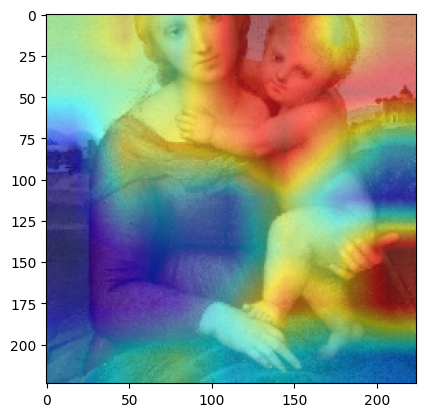

In [4]:
IMAGE_PATH = "../dataset/test/comfort/212.jpg"
LABEL = "danger"

img = read_image(IMAGE_PATH)
transformed_img = transform(img).unsqueeze(0)

with GradCAMPlusPlus(model=model, target_layers=[model.features[-1]], use_cuda=True) as explainer:
  targets = [ClassifierOutputTarget(labels.index(LABEL))]
  cam = explainer(input_tensor=transformed_img, targets=targets)[0, :]

  rgb_img = np.float32(transformed_img.squeeze(0).permute((1, 2, 0)))
  rgb_img = (rgb_img - np.min(rgb_img)) / (np.max(rgb_img) - np.min(rgb_img))

  cam_viz = show_cam_on_image(rgb_img, cam, use_rgb=True)

  plt.imshow(rgb_img)
  plt.imshow(cam_viz)

## Interpret ResNet

In [19]:
finetuned_model = ResNet50ImageClassifier.load_from_checkpoint("../output/resnet50_head/model.ckpt", num_classes=7, lr=0, only_head=False)

model = finetuned_model.model
model.add_module("classifier", finetuned_model.classifier)

train, valid, test = load_image_dataset(Path("../dataset/"), transform=finetuned_model.get_transforms())
labels = train.classes

transform = finetuned_model.get_transforms()

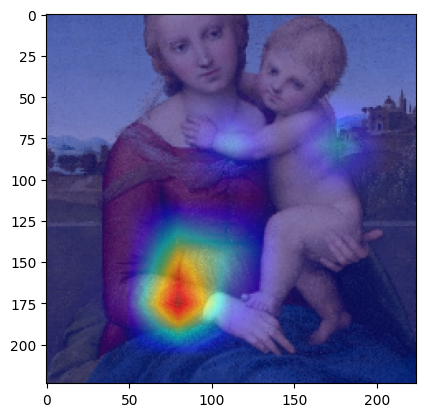

In [12]:
IMAGE_PATH = "../dataset/test/comfort/212.jpg"
LABEL = "death"

img = read_image(IMAGE_PATH)
transformed_img = transform(img).unsqueeze(0)

with GradCAMPlusPlus(model=model, target_layers=[model.layer4], use_cuda=True) as explainer:
  targets = [ClassifierOutputTarget(labels.index(LABEL))]
  cam = explainer(input_tensor=transformed_img, targets=targets)[0, :]

  rgb_img = np.float32(transformed_img.squeeze(0).permute((1, 2, 0)))
  rgb_img = (rgb_img - np.min(rgb_img)) / (np.max(rgb_img) - np.min(rgb_img))

  cam_viz = show_cam_on_image(rgb_img, cam, use_rgb=True)

  plt.imshow(rgb_img)
  plt.imshow(cam_viz)

## Interpret ViT

In [39]:
finetuned_model = ViTImageClassifier.load_from_checkpoint("../output/vit_head/model.ckpt", num_classes=7, lr=0, only_head=False)

model = finetuned_model.model
model.add_module("classifier", finetuned_model.classifier)

train, valid, test = load_image_dataset(Path("../dataset/"), transform=finetuned_model.get_transforms())
labels = train.classes

transform = finetuned_model.get_transforms()

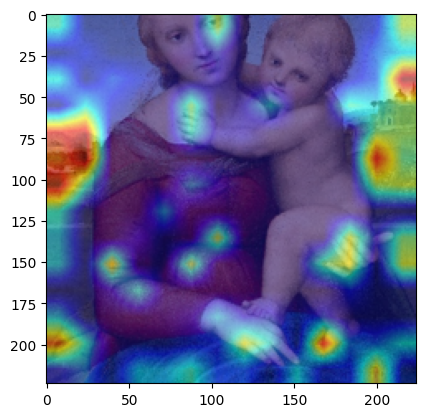

In [67]:
IMAGE_PATH = "../dataset/test/comfort/212.jpg"
LABEL = "death"

img = Image.open(IMAGE_PATH)
transformed_img = transform(img).unsqueeze(0)

def reshape_transform(tensor, height=14, width=14):
    result = tensor[:, 1:, :].reshape(tensor.size(0),
                                      height, width, tensor.size(2))
    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result

with GradCAMPlusPlus(model=model, target_layers=[model.blocks[-1].norm1], use_cuda=True, reshape_transform=reshape_transform) as explainer:
  targets = [ClassifierOutputTarget(labels.index(LABEL))]
  cam = explainer(input_tensor=transformed_img, targets=targets)[0, :]

  rgb_img = np.float32(transformed_img.squeeze(0).permute((1, 2, 0)))
  rgb_img = (rgb_img - np.min(rgb_img)) / (np.max(rgb_img) - np.min(rgb_img))

  cam_viz = show_cam_on_image(rgb_img, cam, use_rgb=True)

  plt.imshow(rgb_img)
  plt.imshow(cam_viz)